In [1]:
import os
path = os.path.abspath(os.getcwd())
print(path)
folder = os.path.split(path)[-1]
if folder == 'Subjects_Scripts':
    print('Subjects_Scripts')
    %run my_imports.py
elif folder == 'MySpaces':
    print('MySpaces')
    %run Subjects_Scripts/my_imports.py

C:\Users\bastien\Documents\Git\python_analysis_2\project\MySpaces\Subjects_Scripts
Subjects_Scripts


In [2]:
# folderSubject = r'D:/DataSet/MySpaces/data/s03'

In [3]:
folderName = os.path.join(folderSubject,'records','fif','agency')

raws_list,events = load_fif_from_folder(folderName,concatFile=False)

raws = mne.concatenate_raws(raws_list)
events = mne.find_events(raws, stim_channel='TRIGGER', shortest_event = 1)
montageFile = os.path.join(folderAnalysis,'locFile','montageANT64_inverse.txt')
layoutFile  = os.path.join(folderAnalysis,'locFile','antneuro_64ch.lay')
chan_dict_file = os.path.join(folderAnalysis,'locfile','chan_dict_64ANT.txt')

f = open(chan_dict_file,'r')
chan_dict = eval(f.read())
     
cfg= {'spatial_filter': 'CAR',
'montage_file':montageFile,
'layout_file':layoutFile}

scale = dict(mag=1e-12, grad=4e-11, eeg=100, eog=150, ecg=500,
     emg=1e3, ref_meg=1e-12, misc=1e-3, stim=1,
     resp=1e3, chpi=1e-4, whitened=1e2)

print(raws.ch_names)

if 'AUX3' in raws.ch_names:
    print("1")
    resp_channel = "AUX3"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX3':'resp','M1':'emg','M2':'emg'}
elif 'AUX7' in raws.ch_names:
    print("2")
    resp_channel = "AUX7"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX7':'resp','M1':'emg','M2':'emg'}
elif 'AUX13' in raws.ch_names:
    print("3")
    resp_channel = "AUX13"
    mapping_channel_type = {'TRIGGER':'stim','EOG':'eog','AUX13':'resp','M1':'emg','M2':'emg'}


raws.set_channel_types(mapping_channel_type)
raws = set_montage_from_file(raws,cfg,kind='topomap')

print('[Preprocessing] Preprocessed Data')

print('[Events Visualization] Checking events')
print(np.unique(events[:,2]))
print('[Events Visualization] Define dictionary for epoching')

[Load Data] Found 6 files
['TRIGGER', 'FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ', 'AUX1', 'AUX13']
3
[Preprocessing] Preprocessed Data
[Events Visualization] Checking events
[ 10  20  30  40  60  70  99 110 112 113 114 115 116 117 118 119]
[Events Visualization] Define dictionary for epoching


In [4]:
raw_filter = raws.copy()
picks_RESP = raw_filter.ch_names.index(resp_channel)
resp_data = np.squeeze(raw_filter.get_data(picks=picks_RESP))
sfreq = raw_filter.info['sfreq']
transient_change = mne.filter.filter_data(resp_data,sfreq=sfreq,l_freq=0.1,h_freq=10)
transient_change = np.reshape(transient_change, (-1, 1)).T 
info = mne.create_info(['AUX3filter'], raws.info['sfreq'], ['ecg'])
stim_raw = mne.io.RawArray(transient_change, info)
raw_filter.add_channels([stim_raw], force_update_info=True)

# Need to inverse that data because of ANTneuro
raw_filter._data = -1*raw_filter._data

# Check if missing data

In [6]:
idx_data_action = np.where(events[:,2] == 30)[0]
trial_remove = []
trialIdx = []
for i,idx_Start in enumerate(idx_data_action):
    if events[idx_Start + 1,2] == 40:
        pass
    else:
        trialIdx.append(i)
        trial_remove.append(idx_Start)
        events[idx_Start-1:idx_Start+2,2] = 0
        
print(trialIdx,trial_remove)

[16, 20, 124, 203, 275, 292] [98, 120, 751, 1227, 1663, 1765]


In [11]:
file = os.path.join(folderName,'pilot_logs.csv')
dataFrame = pd.read_csv(file,header=0)
dataFrame.head()

data_type_frame = dataFrame['trial_type']
data_type = data_type_frame.to_numpy()
data_type = (data_type != 'BMI').astype(int)+1

list_Type_trials = dict(cue=2,self=1)
print(list_Type_trials)

{'cue': 2, 'self': 1}


In [12]:
print(np.shape(data_type))
data_type = np.delete(data_type, trialIdx)
print(np.shape(data_type))

(300,)
(294,)


In [13]:
def min_max_normalization(data):
    return (data - np.nanmin(data))/(np.nanmax(data)-np.nanmin(data))
def zscore_normalization(data):
    return (data - np.nanmean(data))/np.nanstd(data)

In [14]:
agency_rate = dataFrame['agency'].to_numpy()
data_agency = np.zeros(np.shape(agency_rate))
nTrialPerBlock = 60
for i in range(0,len(agency_rate),nTrialPerBlock):
    data_agency_block = agency_rate[i:i+nTrialPerBlock]
    index_remove = np.where(data_agency_block == 0)[0]
    print(index_remove)
    data_agency_block = zscore_normalization(data_agency_block)
    data_agency_block[index_remove] = np.nan
    data_agency[i:i+nTrialPerBlock] = data_agency_block
print('Agency grade normalized an grade 0 set to Nan')

[]
[]
[ 0 28]
[]
[]
Agency grade normalized an grade 0 set to Nan


In [15]:
print(np.shape(data_agency))
data_agency = np.delete(data_agency, trialIdx)
print(np.shape(data_agency))

(300,)
(294,)


In [16]:
listEventOfInterest = {'ST_ACTION':40,'ST_CUE':30}
epochs= mne.Epochs(raw_filter, events, event_id=listEventOfInterest,
                     tmin=-4, tmax=3,baseline=(None), preload = True)
print(epochs)

<Epochs  |   588 events (all good), -4 - 3 sec, baseline off, ~1.07 GB, data loaded,
 'ST_ACTION': 294
 'ST_CUE': 294>


In [17]:
idx_action_event = np.where(events[:,2] == 40)[0]
idx_go_event = np.where(events[:,2] == 30)[0]
idx_start_event = np.where(events[:,2] == 20)[0]
print(len(idx_start_event),len(idx_go_event),len(idx_action_event))

294 294 294


In [57]:
# for idx in range(len(idx_action_event)):
#     if data_type[idx] == list_Type_trials['cue']:
#         events[idx_action_event[idx],2] = 41
#         events[idx_go_event[idx],2] = 31
#         events[idx_start_event[idx],2] = 21
# print('Trials splitted with events')

# Phase Analysis

In [18]:
picks_resp=raw_filter.ch_names.index("AUX3filter")
raw_hilb = raw_filter.copy().pick(picks_resp)
raw_hilb.apply_hilbert([0])

raw_phase = raw_hilb.copy()
raw_phase.apply_function(np.angle,[0])

listEventOfInterest = {'ST_ACTION':40,
                       'ST_GO':30}

epochs_phase  = mne.Epochs(raw_phase, events, event_id=listEventOfInterest,
                         tmin=-4, tmax=4,baseline=None, preload = True)
print(epochs_phase)

<Epochs  |   588 events (all good), -4 - 4 sec, baseline off, ~36.8 MB, data loaded,
 'ST_ACTION': 294
 'ST_GO': 294>


In [19]:
self_based_trials = np.where(data_type == 1)[0]
cue_based_trials = np.where(data_type == 2)[0]
condition_dict_trials = {'SELF':self_based_trials,'CUE':cue_based_trials}
print(np.shape(condition_dict_trials['SELF']))
print(np.shape(condition_dict_trials['CUE']))

(94,)
(200,)


SELF
CUE
SELF
CUE


dict_keys(['ST_ACTION_SELF', 'ST_ACTION_CUE', 'ST_GO_SELF', 'ST_GO_CUE'])

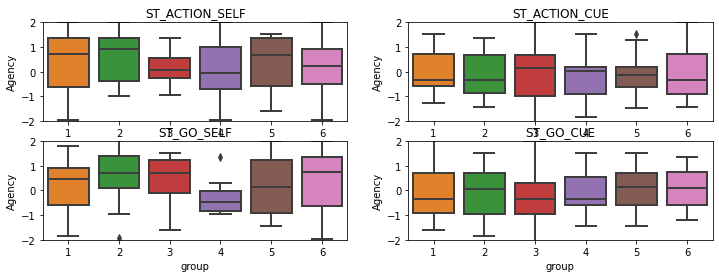

In [20]:
import seaborn as sns
import pandas as pd
from utils.utils_normalization import zscore_over_trials

iplot = 0
nbins = 7
bins = np.linspace(-np.pi, np.pi, nbins)
bins_deg = np.rad2deg(bins);
diff_bins = np.round(bins_deg[1] - bins_deg[0])
index_0 = np.where(epochs_phase.times == 0)[0][0]
df_events = dict()

fig= plt.figure(figsize=(12, 4))
for iEvent,event_type in enumerate(epochs_phase.event_id):
    data_resp = np.squeeze(epochs_phase[event_type]).real
    for key,item in condition_dict_trials.items():
        print(key)
   
        iplot +=1
        # phase respiration for each condition
        data_resp_event = data_resp[item,index_0]
        ind = np.digitize(data_resp_event, bins)
    
        # trials agency
        data_agency_event = data_agency[item]
        agency_phase = []
        resp_phase = []
    
        # Binning Trials
        df = pd.DataFrame()
        for iBin in range(nbins):
            a = data_agency_event * np.array(ind==iBin)
            a[a==0] = np.nan
            agency_phase.append(a)
        
        for iPhase,this_phase in enumerate(agency_phase):
            pmu_trial = this_phase
            a = pd.DataFrame({ 'group' : np.repeat(iPhase,len(pmu_trial)), 'Agency': pmu_trial})
            df = df.append(a)
        df_events.update({event_type+'_'+key:df})
    
        # Plotting
        axs=fig.add_subplot(220+iplot)
        g=sns.boxplot(x='group', y='Agency', data=df,width=0.8,linewidth=2,showfliers = True)
        g.set(title=event_type+'_'+key,xlim=[0.5,nbins-0.5],ylim=[-2,2])
df_events.keys()

# Saving Variable

In [13]:
saving_var('df_events_agency_resp_phase',folderSubject,df_events)
saving_var('epochs_phase',folderSubject,epochs_phase)
saving_var('condition_dict_trials',folderSubject,condition_dict_trials)